# Importing Libraries

In [0]:
import tqdm
import time
from contextlib import contextmanager
import os, argparse
import cv2, spacy, numpy as np
# from sklearn.externals import joblib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import csv
import glob
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# from pyimagesearch import config
from imutils import paths
import numpy as np
import pickle
import operator
from operator import itemgetter
from itertools import zip_longest
from collections import defaultdict
import json
import joblib
import random
from nltk.tokenize.treebank import TreebankWordTokenizer
import matplotlib.image as mpimg

# Loading Data

In [0]:
def getAllAnswer(answers_list):
	"""
	Joins a list of answers by ";" to a single string
	
	Input:
		answer_list: list of answers (there are 10 answers for every question)

	Returns:
		A string in the format "ans1;ans2;...;ans10"
	"""
	answers = []
	for i in range(len(answers_list)):
		answers.append(answers_list[i]['answer'])
	return ';'.join(answers)

In [0]:
# https://github.com/shiyangdaisy23/QTA-in-VQA/blob/master/Datapreprocess/textpreprocess.py
def process_question_annotation(subset):
    """
    Creates a JSON file whose elements are (image_path, question, answer, answers)
    from the Questions and Annotations files.

    Input:
      subset: subset can be "train2014" or "val2014"

    Returns:
      None
    """
    anno = json.load(open(f'/content/v2_mscoco_{subset}_annotations.json', 'r'))
    ques = json.load(open(f'/content/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm.tqdm(range(len(anno['annotations']))):
        image_path = imdir%(subset, subset, anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        ans = anno['annotations'][i]['multiple_choice_answer']
        answer_list = getAllAnswer(anno['annotations'][i]['answers'])
        data.append({'img_path': image_path, 'question': question, 'ans': ans, 'answers': answer_list})

    json.dump(data, open(f'/content/drive/My Drive/Capstone/VisualQA/processed_data/vqa_raw_{subset}.json', 'w'))

In [0]:
subset = ['train2014', 'val2014']

with timer('Processing Questions and Annotations:'):
  for x in subset:
    process_question_annotation(x)

100%|██████████| 214354/214354 [00:00<00:00, 283288.74it/s]


[Processing Questions and Annotations:] done in 22 s


In [0]:
train_data = json.load(open(f'/content/drive/My Drive/Capstone/VisualQA/processed_data/vqa_raw_train2014.json', 'r'))
val_data = json.load(open(f'/content/drive/My Drive/Capstone/VisualQA/processed_data/vqa_raw_val2014.json', 'r'))

# EDA

Let's analyse the dataset:

In [0]:
ques = list(map(itemgetter('question'), train_data))
ans = list(map(itemgetter('ans'), train_data))
image_list = list(map(itemgetter('img_path'), train_data))

## 1 Images

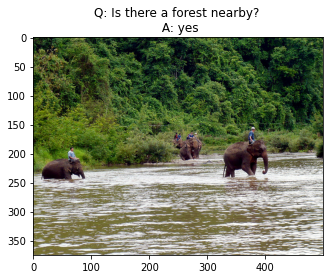

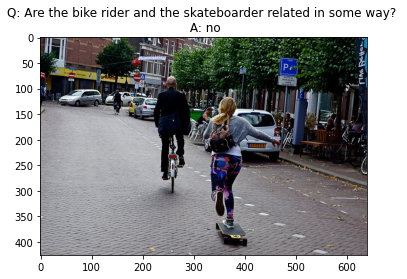

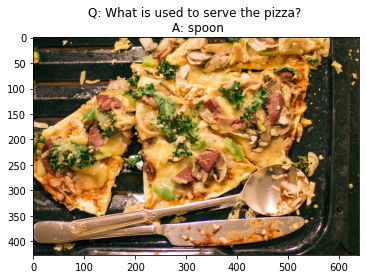

In [0]:
# https://stackoverflow.com/a/41210974
def process(index, image_file, question, answer):
    image = mpimg.imread(image_file[index])
    plt.figure()
    plt.title(f'Q: {question[index]} \n A: {answer[index]}')
    plt.imshow(image)

idx = random.sample(range(0, len(image_list)), 3)
for i in idx:
    process(i, image_list, ques, ans)

We can see that the shape of the images are different:

In [0]:
image_files = os.listdir('train2014')
image_info = []

for image_file in (image_files):
  img = cv2.imread(os.path.join('train2014/',image_file))
  image_info.append(img.shape)

In [0]:
heights = list(map(itemgetter(0), image_info)) 
widths = list(map(itemgetter(1), image_info)) 
channel = list(map(itemgetter(2), image_info)) 

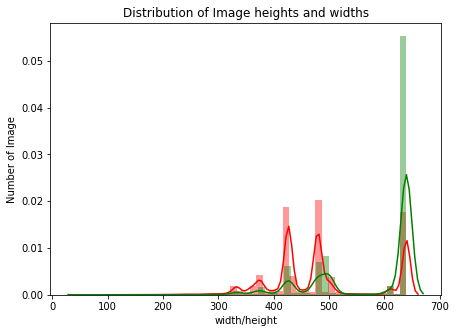

In [0]:
plt.figure(figsize=(7,5))
sns.distplot(heights, color='red')
sns.distplot(widths, color='green')
plt.title('Distribution of Image heights and widths')
plt.xlabel('width/height')
plt.ylabel('Number of Image')
plt.show()

In [0]:
print("MAX Height: {}, MIN Height: {}, MEAN Height: {}".format(max(heights), min(heights), np.round(np.mean(heights),2)))
print("MAX Width: {}, MIN Width: {}, MEAN Width: {}".format(max(widths), min(widths), np.round(np.mean(widths),2)))

MAX Height: 640, MIN Height: 51, MEAN Height: 483.59
MAX Width: 640, MIN Width: 59, MEAN Width: 578.05


In [0]:
print(len(set(channel)))

1


In [0]:
print('All the images have same channel depth of {}.'.format(int(list(set(channel))[0])))

All the images have same channel depth of 3.


## 2 Questions

### Raw Data:

Let's look at few questions samples selected at random:

In [0]:
idx = random.sample(range(0, len(ques)), 20)

In [0]:
for i in (idx):
  print(ques[i])
  print('_'*50)

What is in the glass closest to the lady?
__________________________________________________
Are there mountains in the image?
__________________________________________________
What date is being advertised?
__________________________________________________
What is the name of this street?
__________________________________________________
What is the light green item?
__________________________________________________
Is the water placid?
__________________________________________________
What is the grate on the floor?
__________________________________________________
What is the man wearing?
__________________________________________________
Where is the man skateboarding?
__________________________________________________
Is it day time?
__________________________________________________
How many sheep are standing in picture?
__________________________________________________
What does the woman have on her back?
__________________________________________________
Are these onio

In [0]:
idx2 = random.sample(range(0, len(ques)), 20)

In [0]:
for i in (idx2):
  print(ques[i])
  print('_'*50)

How many steps are there?
__________________________________________________
What color is the sky?
__________________________________________________
What material is the wall constructed of?
__________________________________________________
Is he throwing a baseball?
__________________________________________________
How many slices can you see?
__________________________________________________
Where does it say "1560 m"?
__________________________________________________
Where are the books?
__________________________________________________
Does this bathtub have a shower also?
__________________________________________________
Is this child in danger of falling off of the refrigerator?
__________________________________________________
What color is the apple?
__________________________________________________
What beverages are on the table?
__________________________________________________
What maneuver did the skateboarder have to complete in order to get on the railing?
___

- Most of the questions are simple and clean text.
- Some questions contain common word contractions like: __it's__, __they're__, etc. And noun contractions like: __man's__, __dog's__, etc.
- Few words contain __hyphen__, eg: man-made
- Few words contain __quotes__, eg: "1560 m", etc.

Hence, we need to perform some data cleaning operations on our data.



In [0]:
length_list = []
word_all = []
for i in tqdm.tqdm(ques):
    length_list.append(len(i.split(" ")))
    for j in i.split(" "):
        word_all.append(j)
set_all = set(word_all)

100%|██████████| 443757/443757 [00:01<00:00, 411628.10it/s]


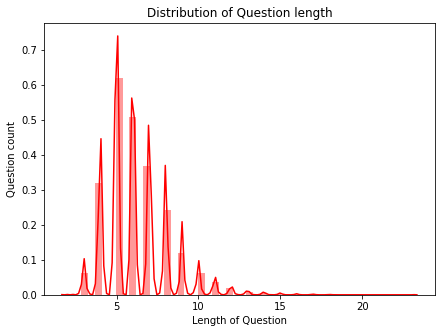

In [0]:
%matplotlib inline
plt.figure(figsize=(7,5))
sns.distplot(length_list, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.show()

In [0]:
print('BEFORE DATA CLEANING')
print('-'*35)
print("A sentence has max words:",max(length_list))
print("A sentence has min words:",min(length_list))
print('A sentence has average words:',int(sum(length_list)/len(length_list)))
print('There are total',len(set_all),'unique words')

BEFORE DATA CLEANING
-----------------------------------
A sentence has max words: 23
A sentence has min words: 2
A sentence has average words: 6
There are total 22226 unique words


In [0]:
list_1 = []
for k in set_all:
    alphabet = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM0123456789'
    for l in alphabet:
        k = k.replace(l,'')
    list_1.append(k)

#merge all the non-alphabet characters in 'list_1' to one single list 'set_1'
str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

#concatanate all the special symbols to a single string 'SYMBOLS_TO_REMOVE'
SYMBOLS_TO_REMOVE = ''.join(a for a in set_1)
print('There are total',len(SYMBOLS_TO_REMOVE),'non-alphabet characters (including digits) in our corpus.')

There are total 21 non-alphabet characters (including digits) in our corpus.


In [0]:
print("These are:")
print(SYMBOLS_TO_REMOVE)

These are:
,+;*?-!^(:"`)/'$_#.%&


### Data Cleaning:

In [0]:
# https://github.com/zcyang/imageqa-san
import re

def process_sentence(sentence):
    """
    Cleans a given raw sentence

    Input:
        sentence: a raw sentence

    Returns:
        Returns the cleaned version of the sentence
    """
    # remove the character ".", except from floating numbers
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # remove any "," between digits, eg: 5,6
    commaStrip   = re.compile("(\d)(\,)(\d)")
    # list of punctuations to remove
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '*', ':', '^', '%', '$', '#', '&',
                    '>', '<', '@', '`', ',', '?', '!']
    # contraction mappings
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                    "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "where's": "where is", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    # replace new line with a white space
    inText = sentence.replace('\n', ' ')
    # replace multiple white space with single white space
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

Let's see the working of the __process_sentence__ function:

In [0]:
datas = ["Is the snow in this picture probably natural , or probably man-made ?", 
         "What color is the woman's shirt?",
         "Where's the man looking at?"]

In [0]:
for data in datas:
  print('BEFORE: ', data)
  temp = process_sentence(data)
  print('AFTER : ', temp)
  print('-'*50)

BEFORE:  Is the snow in this picture probably natural , or probably man-made ?
AFTER :  is the snow in this picture probably natural or probably man made
--------------------------------------------------
BEFORE:  What color is the woman's shirt?
AFTER :  what color is the woman's shirt
--------------------------------------------------
BEFORE:  Where's the man looking at?
AFTER :  where is the man looking at
--------------------------------------------------


- We can see that the symbols from `SYMBOLS_TO_REMOVE` are removed. 
- The common word contractions are replaced with their expanded form. However, we do not make any changes to noun contractions.

Now, we clean our dataset:

In [0]:
questions_train_processed = pd.Series(ques).apply(process_sentence)

Let's look at few examples from our dataset to understand the transformations:

In [0]:
# raw data
ques[:10]

['What is this photo taken looking through?',
 'What position is this man playing?',
 'What color is the players shirt?',
 'Is this man a professional baseball player?',
 'What color is the snow?',
 'What is the person doing?',
 'What color is the persons headwear?',
 "What is in the person's hand?",
 'Is the dog waiting?',
 'Is the dog looking at a tennis ball or frisbee?']

In [0]:
# cleaned data
list(questions_train_processed[:10])

['what is this photo taken looking through',
 'what position is this man playing',
 'what color is the players shirt',
 'is this man a professional baseball player',
 'what color is the snow',
 'what is the person doing',
 'what color is the persons headwear',
 "what is in the person's hand",
 'is the dog waiting',
 'is the dog looking at a tennis ball or frisbee']

In [0]:
length_list = []
word_all = []
for i in tqdm.tqdm(questions_train_processed):
    length_list.append(len(i.split(" ")))
    for j in i.split(" "):
        word_all.append(j)
set_all = set(word_all)

100%|██████████| 443757/443757 [00:01<00:00, 432347.62it/s]


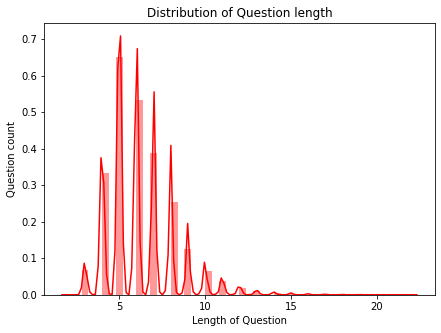

In [0]:
plt.figure(figsize=(7,5))
sns.distplot(length_list, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.show()

In [0]:
print('AFTER DATA CLEANING')
print('-'*35)
print("A sentence has max words:", max(length_list))
print("A sentence has min words:", min(length_list))
print('A sentence has average words:',int(sum(length_list)/len(length_list)))
print('There are total', len(set_all),'unique words')

AFTER DATA CLEANING
-----------------------------------
A sentence has max words: 22
A sentence has min words: 2
A sentence has average words: 6
There are total 13744 unique words


### Further Analysis:

We are done with text cleaning. Now, let's aggregate the first word of each question to a list.

This will help us understand the type of question present in the dataset and also their distributions:


In [0]:
first_word_list = []
for question in tqdm.tqdm(questions_train_processed):
  first_word_list.append(question.split()[0].lower())

100%|██████████| 443757/443757 [00:00<00:00, 951599.12it/s]


In [0]:
print('There are ',len(set(first_word_list)),' type of questions in the dataset.')

There are  271  type of questions in the dataset.


Let's look at the top 10 question types:

In [0]:
ques_freq= defaultdict(int)
for key in list(first_word_list):
		ques_freq[key] += 1

sorted_freq = sorted(ques_freq.items(), key=operator.itemgetter(1), reverse=True)[0: 10]
top_questions, top_freq = zip(*sorted_freq)

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Question Type", "Question Count", "Coverage"])

for i in range(10):
    row = []
    row.append(top_questions[i])
    row.append(top_freq[i])
    row.append(np.round((top_freq[i]/sum(top_freq))*100, 2))
    x.add_row(row)

print(x)

+---------------+----------------+----------+
| Question Type | Question Count | Coverage |
+---------------+----------------+----------+
|      what     |     182842     |   42.9   |
|       is      |     113774     |   26.7   |
|      how      |     53426      |  12.54   |
|      are      |     33136      |   7.78   |
|     where     |     12409      |   2.91   |
|      does     |     12021      |   2.82   |
|     which     |      5382      |   1.26   |
|       do      |      4983      |   1.17   |
|      why      |      4891      |   1.15   |
|      who      |      3322      |   0.78   |
+---------------+----------------+----------+


Word Cloud for Question data:

In [0]:
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15,12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Let's look at the WordCloud for questions word vocab (all the words present in question data):

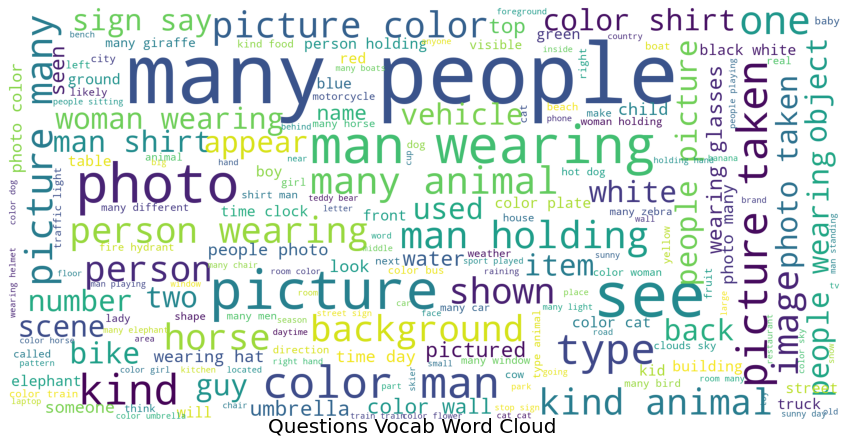

In [0]:
show_wordcloud(word_all, title = 'Questions Vocab Word Cloud')

## 3 Answers

In [0]:
answer_freq= defaultdict(int)
for answer in list(map(itemgetter('ans'), train_data)):
		answer_freq[answer] += 1

sorted_freq = sorted(answer_freq.items(), key=operator.itemgetter(1), reverse=True)[0: 1000]
top_answers, top_freq = zip(*sorted_freq)

In [0]:
print('There are total ', len(answer_freq), ' different types of answers.')

There are total  22531  different types of answers.


Let's see the answer distribution:

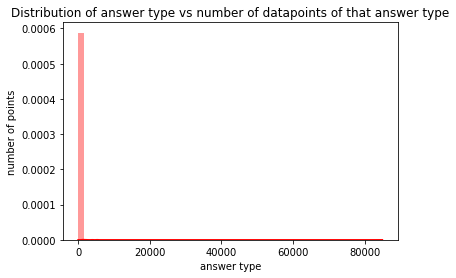

In [0]:
sns.distplot(list(answer_freq.values()), color='red')
plt.title('Distribution of answer type vs number of datapoints of that answer type')
plt.xlabel('answer type')
plt.ylabel('number of points')
plt.show()

- The answer to most qustions belong to few classes only.

Let's look at the cumulative distribution:

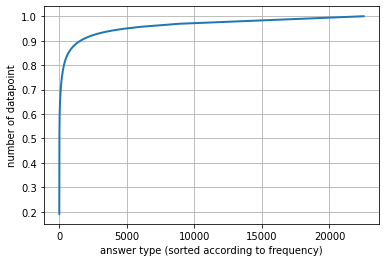

In [0]:
answer_count = sorted(list(answer_freq.values()), reverse=True) / np.sum(list(answer_freq.values()));
answer_count_cum = np.cumsum(answer_count)
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(answer_count_cum, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('answer type (sorted according to frequency)')
plt.ylabel('number of datapoint')
plt.show()

In [0]:
threshold = 0.875
idx = [i for i, elem in enumerate(answer_count_cum) if elem > threshold][0]
print(f'Top {idx + 1} answer-type covers about {threshold * 100}% of our train data')

Top 1005 answer-type covers about 87.5% of our train data


Let's look at the top 10 answers:

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Question Type", "Question Count", "Coverage(%)"])

for i in range(10):
    row = []
    row.append(top_answers[i])
    row.append(top_freq[i])
    row.append(np.round((top_freq[i]/sum(top_freq))*100, 2))
    x.add_row(row)

print(x)

+---------------+----------------+-------------+
| Question Type | Question Count | Coverage(%) |
+---------------+----------------+-------------+
|      yes      |     84978      |    21.89    |
|       no      |     82516      |    21.26    |
|       1       |     12540      |     3.23    |
|       2       |     12215      |     3.15    |
|     white     |      8916      |     2.3     |
|       3       |      6536      |     1.68    |
|      blue     |      5455      |     1.41    |
|      red      |      5201      |     1.34    |
|     black     |      5066      |     1.31    |
|       0       |      4977      |     1.28    |
+---------------+----------------+-------------+
